# Building an optical system using ``GaussOpt``

``GaussOpt`` can be used to analyze quasioptical systems using Gaussian beam analysis. In this notebook, we walk through the basics of setting up a Gaussian beam telescope.

In [1]:
%matplotlib inline
from gaussopt import *
import matplotlib.pyplot as plt 

# Formatting for Matplotlib (optional)
# pip install SciencePlots
plt.style.use(["science", "notebook"])

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## Gaussian beam telescopes

Gaussian beam telescopes use two parabolic mirrors to couple energy between two horn antennas. If the mirrors have focal lengths $f$, then the mirrors should be separated by $2\,f$ and the distance between each horn's beam waist and its respective mirror should be $f$ (as shown below).

![](misc/GaussianBeamTelescope.jpg)

We will now build a quick script to analyze a Gaussian beam telescope.

## Define frequency sweep

For this notebook, we will sweep the frequency from 150 GHz to 300 GHz. This is done using using the ``gaussopt.Frequency`` class.

In [2]:
freq = Frequency(start=150, stop=300, npts=151, units='GHz')

Frequency sweep: 
	f = 150.0 to 300.0 GHz, step 1.0 GHz, 151 pts



## Define horn antennas

Horn antennas are defined by their slant length, aperture radius and horn factor. See Chapter 7 of "Quasioptical Systems" by Paul Goldsmith for more information. 

We will use the ``gaussopt.Horn`` class to generate the transmitting horn (``horn_tx``) and then copy this horn to generate the receiving horn (``horn_rx``). We will use a corrugated circular feed horn, which has a horn factor of 0.64.

![title](misc/Horn.jpg)

In [3]:
slen = 22.64  # slant length (in mm)
arad = 3.6    # aperture radius (in mm)
hfac = 0.64   # horn factor (see chp. 7 of Quasioptical Systems)

horn_tx = Horn(freq, slen, arad, hfac, units='mm', comment='Trasmitting')
horn_rx = horn_tx.copy(comment='Receiving')

Horn: Trasmitting
	slen = 22.64 mm
	arad =  3.60 mm
	hf   =  0.64

Horn: Receiving
	slen = 22.64 mm
	arad =  3.60 mm
	hf   =  0.64



## Define optical components

Now it is time to build the rest of the circuit, i.e., everything between the transmitting and receiving horns. We can define empty space using the ``gaussopt.Freespace`` class and mirrors using the ``gaussopt.Mirror`` class.

In [4]:
# 16 cm of freespace (air)
d = FreeSpace(160)

# Mirrors with a focal length of 16 cm
m1 = Mirror(16, units='cm', radius=8, comment='M1')
m2 = m1.copy(comment='M2')

Free space: 
	d = 160.0 mm

Mirror: M1
	f = 16.0 cm

Mirror: M2
	f = 16.0 cm



The distances between the horns and the mirrors have to be reduced because the actual beam waist is behind the horn aperture.

In [5]:
# Offset distance (i.e., distance from beam waist to horn aperture) at 230 GHz
z_offset = horn_tx.z_offset(units='mm')[freq.idx(230, units='GHz')]

# Ideal distance between horn aperture and mirror
d_red = FreeSpace(160 - z_offset, comment='reduced')

Free space: reduced
	d = 154.5 mm



## Build Optical System

We can now combine all of the individual optical components to build our optical system. This is normally done by creating a list of optical components (``component_list`` below), starting from the transmitting horn and then listing each component to the receiving horn (in order).

The component list is then passed to the ``gaussopt.System`` class, along with the two horns, to calculate the system properties.

In [6]:
component_list = (d_red, m1, d, d, m2, d_red)

system = System(horn_tx, component_list, horn_rx)

System: 
[[-1.          0.01096053]
 [ 0.         -1.        ]]



## Plot Coupling

The coupling between the two horns can be plotted using the ``plot_coupling`` method. There should be perfect coupling at the center frequency.

Best coupling: 100.0% at 230.0 GHz


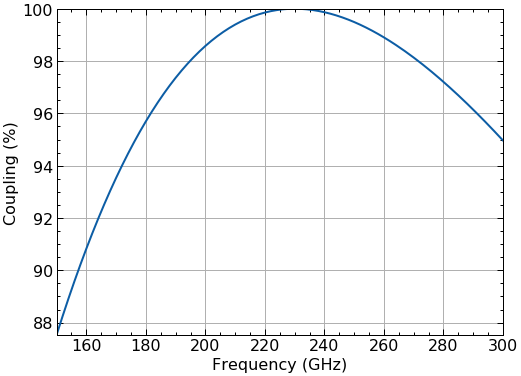

In [7]:
system.plot_coupling()
system.print_best_coupling()

## Plot Beam Propagation

The beam waist can be plotted through the entire chain using the ``plot_system`` command. This method will also plot the aperture of each component to ensure that there isn't too much edge taper anywhere in the system.

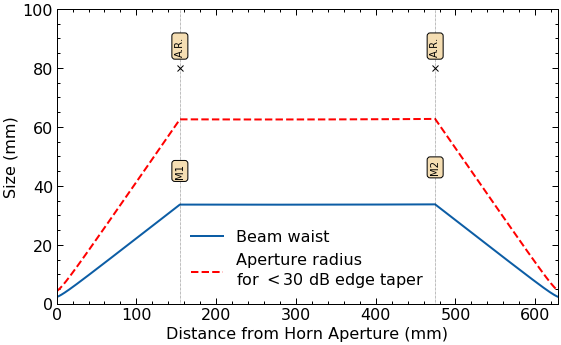

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
system.plot_system(ax=ax)